In [1]:
%pylab inline

# Import our plot library
from vplot import *

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Polygon
import scipy.stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import seaborn as sns; sns.set(style="white", color_codes=True)

SIMDIR="/storage/ileena/simulation/SSC/fig_haplo_paper/"
DATADIR="/storage/mgymrek/ssc-imputation/"
OUTPATH="pdfs/"
PREFIX="Figure4"
REGION="chr21_23934706"

Populating the interactive namespace from numpy and matplotlib


# Figure 4A: Example STR gt vs. pt

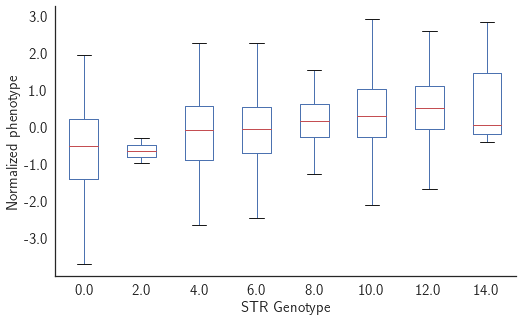

In [72]:
# Load data for example
#ex_gt_data = pd.read_csv(os.path.join(SIMDIR, REGION+ "_STR_21_23934706.gt"), sep="\t")
#ex_pt_data = pd.read_csv(os.path.join(SIMDIR, REGION+ "_0.pheno"), sep="\t", names=["Sample_ID", "x", "pt"])
ex_gt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_quant_example_STR_21_23934706.gt"), sep="\t")
ex_pt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_quant_example_0.pheno"), sep="\t", names=["Sample_ID", "x", "pt"])

ex_data = pd.merge(ex_gt_data, ex_pt_data, on=["Sample_ID"])
ex_data["gt"] = ex_data["True_STR_Sum"]

# Figure
fig = plt.figure()
fig.set_size_inches((8, 5))
ax = fig.add_subplot(111)
ex_data.boxplot(column="pt", by="gt", ax=ax, grid=False);

ax.set_title("")
plt.suptitle("");
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.set_xlabel("STR Genotype", size=15)
ax.set_ylabel("Normalized phenotype", size=15);
ax.set_xticklabels(ax.get_xticklabels(), size=15);
ax.set_yticks(np.arange(-3, 3.1, 1))
ax.set_yticklabels(ax.get_yticks(), size=15);
fig.savefig(os.path.join(OUTPATH, "%s_ExampleAssociation.pdf"%PREFIX))

# Figure 4B: LD vs. p-value

In [83]:
r2 = pd.read_csv(os.path.join(DATADIR, "gwas-power", "r2_snp.tab"), sep="\t")
r2_imp = pd.read_csv(os.path.join(DATADIR, "gwas-power", "r2_imp.tab"), sep="\t")
assoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_quant_example_power_simulation_results.txt"), sep="\t")
str_coord = assoc[assoc["testclass"]=="STR"]["locus"].values[0]

# Pull out SNPs
r2 = r2[r2["locus1"]==str_coord]
r2["locus"] = r2["locus2"]
snp_assoc = assoc[assoc["testclass"]=="SNP"]
snp_assoc = pd.merge(snp_assoc, r2, on=["locus"])

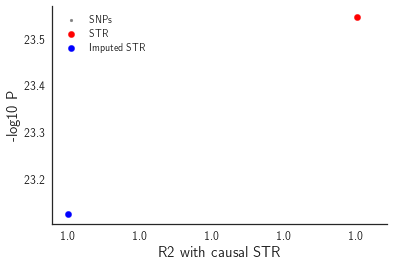

In [84]:
fig = plt.figure()
fig.set_size_inches((6, 4))
ax = fig.add_subplot(111)

# Plotting all SNPs
ax.scatter(snp_assoc["r2"], snp_assoc["pvalue"].apply(lambda x: -1*np.log10(x)), color="gray", s=8, label="SNPs");

# Plot the STR
ax.scatter([1.0], [assoc[assoc["testclass"]=="STR"]["pvalue"].apply(lambda x: -1*np.log10(x)).values[0]], color="red", s=40, label="STR")

# Plot the imputed STR
imp_ld = r2_imp[r2_imp["locus1"]==str_coord]["r2"].values[0]
imp_p = assoc[assoc["testclass"]=="IMPSTR"]["pvalue"].apply(lambda x: -1*np.log10(x)).values[0]
ax.scatter([imp_ld], [imp_p], color="blue", s=40, label="Imputed STR");

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.set_xlabel("R2 with causal STR", size=15)
ax.set_ylabel("-log10 P", size=15);
ax.set_xticklabels(["%.1f"%x for x in ax.get_xticks()], size=12)
ax.set_yticklabels(["%.1f"%x for x in ax.get_yticks()], size=12)
ax.legend(loc="upper left");
fig.savefig(os.path.join("%s_r2vsP.pdf"%PREFIX))

# Figure 4C

In [55]:
# Load LD values
snpstr = pd.read_csv(os.path.join(DATADIR, "gwas-power","r2_snp.tab"), sep="\t")
best_snp = snpstr.groupby("locus1", as_index=False).agg({"r2": max, "freq_het": np.mean})
sscloo = pd.read_csv(os.path.join(DATADIR, "gwas-power","r2_imp.tab"), sep="\t")
r2comp = pd.merge(best_snp, sscloo, on=["locus1"])[["locus1","freq_het_x","r2_x","r2_y"]]
r2comp.columns = ["locus","het","r2_bestsnp","r2_ssc"]
r2comp["r2diff"] = r2comp["r2_ssc"]-r2comp["r2_bestsnp"]

251


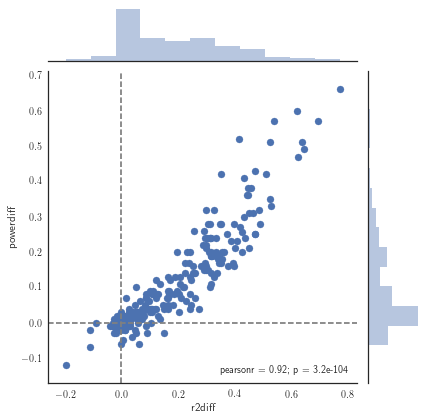

In [62]:
# Computer power for each association
#assoc = pd.read_csv(os.path.join(SIMDIR, "100sims_chr21_power_simulation_results.txt"), sep="\t") #final file
#assoc = pd.read_csv(SIMDIR+"bestSNP_chr21_power_simulation_results.txt", sep="\t") #test file
#assoc = pd.read_csv("/home/mgymrek/workspace/ssc-imputation/gwas-power/test_power_simulation_results.txt", sep="\t")
assoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_quant.tab_power_simulation_results.txt"), sep="\t")

def GetPower(x, alpha=0.05):
    return np.mean([(int(float(item) < alpha)) for item in x])

# Calculate power for each class
assoc_tmp = assoc.groupby(["str","testclass"], as_index=False).agg({"pvalue": lambda x: GetPower(x)})
assoc_tmp["power"] = assoc_tmp["pvalue"]
assoc_tmp = assoc_tmp[["str","testclass","power"]]

impdata = assoc_tmp[assoc_tmp["testclass"]=="IMPSTR"].copy()
snpdata = assoc_tmp[assoc_tmp["testclass"]=="SNP"].copy()
strdata = assoc_tmp[assoc_tmp["testclass"]=="STR"].copy()
impdata["imp_power"] = impdata["power"]
snpdata["snp_power"] = snpdata["power"]
strdata["str_power"] = strdata["power"]
power = pd.merge(impdata[["str","imp_power"]], snpdata[["str", "snp_power"]], on=["str"])
power = pd.merge(power, strdata[["str","str_power"]], on=["str"])
power["powerdiff"] = power["imp_power"] - power["snp_power"]
power["locus"] = power["str"]
data = pd.merge(power, r2comp, on=["locus"])

subdata = data#[data["snp_power"]<1]
g = sns.jointplot(x="r2diff", y="powerdiff", data=subdata)
g.ax_joint.axvline(x=0, linestyle="dashed", color="gray")
g.ax_joint.axhline(y=0, linestyle="dashed", color="gray")

print(data.shape[0])

In [38]:
# Mean gain in r2 vs. num alleles
sscloo = pd.read_csv(os.path.join(DATADIR, "loo","l1o.results.csv"))
sscloo["locus"] = sscloo["str"]
ldata = pd.merge(sscloo, r2comp, on=["locus"])
print(np.mean(ldata[(ldata["numAllele"]>=3)]["r2diff"]))
print(np.mean(ldata["r2diff"]))

0.20789935248852326
0.1886586749136088


# Supplementary Figure: r2imp-r2best vs. num alleles

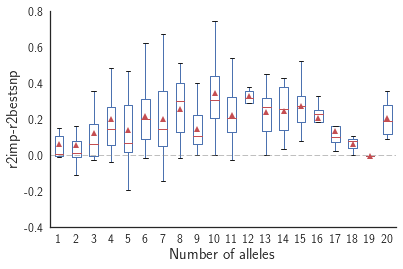

In [39]:
fig = plt.figure()
fig.set_size_inches((6, 4))
ax = fig.add_subplot(111)
ldata[ldata["numAllele"]<=20].boxplot(column="r2diff", by="numAllele", grid=False, ax=ax, showmeans=True);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.axhline(y=0, linestyle="dashed", color="gray", linewidth=0.5)
ax.set_ylim(bottom=-0.4, top=0.8)
ax.set_title("")
plt.suptitle("")
ax.set_xlabel("Number of alleles", size=15)
ax.set_ylabel("r2imp-r2bestsnp", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(["%.1f"%x for x in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTPATH, "SuppFig_r2gain.pdf"))

# Supplementary Figure: case/control - TODO

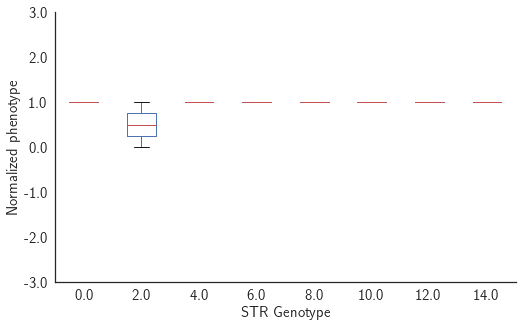

In [92]:
# Load data for example
exp_gt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_cc_example_STR_21_23934706.gt"), sep="\t")
exp_pt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_cc_example_0.pheno"), sep="\t", names=["Sample_ID", "x", "pt"])

ex_data = pd.merge(exp_gt_data, exp_pt_data, on=["Sample_ID"])
ex_data["gt"] = ex_data["True_STR_Sum"]

# Figure
fig = plt.figure()
fig.set_size_inches((8, 5))
ax = fig.add_subplot(111)
ex_data.boxplot(column="pt", by="gt", ax=ax, grid=False);

ax.set_title("")
plt.suptitle("");
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.set_xlabel("STR Genotype", size=15)
ax.set_ylabel("Normalized phenotype", size=15);
ax.set_xticklabels(ax.get_xticklabels(), size=15);
ax.set_yticks(np.arange(-3, 3.1, 1))
ax.set_yticklabels(ax.get_yticks(), size=15);
fig.savefig(os.path.join(OUTPATH, "SuppFig_ExampleAssociation.pdf"))

In [90]:
r2 = pd.read_csv(os.path.join(DATADIR, "gwas-power", "r2_snp.tab"), sep="\t")
r2_imp = pd.read_csv(os.path.join(DATADIR, "gwas-power", "r2_imp.tab"), sep="\t")
assoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_cc_example_power_simulation_results.txt"), sep="\t")
str_coord = assoc[assoc["testclass"]=="STR"]["locus"].values[0]

# Pull out SNPs
r2 = r2[r2["locus1"]==str_coord]
r2["locus"] = r2["locus2"]
snp_assoc = assoc[assoc["testclass"]=="SNP"]
snp_assoc = pd.merge(snp_assoc, r2, on=["locus"])

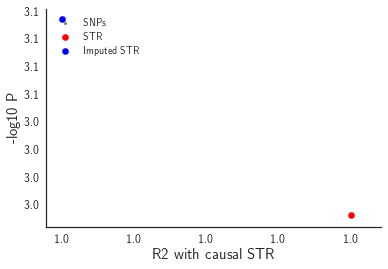

In [73]:
fig = plt.figure()
fig.set_size_inches((6, 4))
ax = fig.add_subplot(111)

# Plotting all SNPs
ax.scatter(snp_assoc["r2"], snp_assoc["pvalue"].apply(lambda x: -1*np.log10(x)), color="gray", s=8, label="SNPs");

# Plot the STR
ax.scatter([1.0], [assoc[assoc["testclass"]=="STR"]["pvalue"].apply(lambda x: -1*np.log10(x)).values[0]], color="red", s=40, label="STR")

# Plot the imputed STR
imp_ld = r2_imp[r2_imp["locus1"]==str_coord]["r2"].values[0]
imp_p = assoc[assoc["testclass"]=="IMPSTR"]["pvalue"].apply(lambda x: -1*np.log10(x)).values[0]
ax.scatter([imp_ld], [imp_p], color="blue", s=40, label="Imputed STR");

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.set_xlabel("R2 with causal STR", size=15)
ax.set_ylabel("-log10 P", size=15);
ax.set_xticklabels(["%.1f"%x for x in ax.get_xticks()], size=12)
ax.set_yticklabels(["%.1f"%x for x in ax.get_yticks()], size=12)
ax.legend(loc="upper left");
fig.savefig(os.path.join("SuppFig_r2vsP.pdf"))

# DEBUG below

In [32]:
ldata.shape

(12, 17)

In [12]:
#assoc[(assoc["str"]=="21:29968086") & (assoc["testclass"]=="SNP")]["pvalue"]
assoc[(assoc["str"]=="21:34834110") & (assoc["testclass"]=="IMPSTR")].sort_values("pvalue", ascending=False)

,str,locus,testclass,simnum,beta,pvalue
1014487,21:34834110,21:34834110,IMPSTR,62,0.194822,1.108246e-05
1014430,21:34834110,21:34834110,IMPSTR,43,0.205728,4.497221e-06
1014478,21:34834110,21:34834110,IMPSTR,59,0.199323,4.154234e-06
1014577,21:34834110,21:34834110,IMPSTR,92,0.200285,2.326012e-06
1014520,21:34834110,21:34834110,IMPSTR,73,0.219534,2.895552e-07
1014589,21:34834110,21:34834110,IMPSTR,96,0.229280,2.035378e-07
1014511,21:34834110,21:34834110,IMPSTR,70,0.226818,1.764832e-07
1014364,21:34834110,21:34834110,IMPSTR,21,0.220899,1.355925e-07
1014475,21:34834110,21:34834110,IMPSTR,58,0.228810,1.158978e-07
1014337,21:34834110,21:34834110,IMPSTR,12,0.226017,1.011856e-07
